## Tutorial of drug screening 

1. Run gsea_proc.py to perform GSEA analysis of all drugs on predicted post-perturbation profiles and ground truth.
   It requires perturbation dataset (we provide [sciplex3_pp_hvgenes_scFM_resplit.h5ad](https://drive.google.com/file/d/1MWRvhb-PfANxg011RNgXGFiQrCc0YRXJ/view?usp=drive_link)) and trained model weights [sciplex3_split2_model.pt](https://drive.google.com/file/d/1xsP6S988YhBXiIbxabnI2UdREdjYAhEx/view?usp=drive_link).
2. Get gsea results and precision file(you can use the given K562_gsea_acc.pkl). Evaluate and plot with gsea_evaluation.ipynb.

In [12]:
import pickle 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Identify anti-cancer drugs as reference

In [2]:
# Get from gsea_proc.py
with open('K562_gsea_acc.pkl','rb') as f:
    re = pickle.load(f)

drugs = list(re.keys())

In [3]:
# Defined CML-related pathways
cml_related_pathways = [
    'KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION',
    'KEGG_PATHWAYS_IN_CANCER',
    'PID_PDGFRB_PATHWAY',
    'REACTOME_RHO_GTPASE_CYCLE',
    'REACTOME_SIGNALING_BY_RHO_GTPASES_MIRO_GTPASES_AND_RHOBTB3',
    'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR',
    'KEGG_CHRONIC_MYELOID_LEUKEMIA',
]

In [10]:
# Identify anti-cancer drugs according to gsea results of ground truth and CML-related pathways
anti_drugs = []
l_l = []
anti = []
not_d = {}
for d in drugs:
    truth = pd.read_csv(f'./gsea/{d}_gsea_truth.csv',index_col=0)
    if len(truth[truth['NES']<0]) > 0: # We only consider down-regulated pathways
        if truth.loc[(truth['NES']<0),'Term'].isin(cml_related_pathways).any()>0:
            anti_drugs.append(d)
            l_l.append(len(truth[truth['NES']<0]))
            anti.append(True)
        else:
            anti.append(False)
            not_d[d]=len(truth[truth['NES']<0])
    else:
        anti.append(False)

Calculate enrichment scores of candidate drugs

In [7]:
score_l = []
# Compute enrichment scores for each drug, which is the sum of NES of down-regulated CML-related pathways
for d in drugs:
    pred = pd.read_csv(f'/Users/liuxinyuan/Desktop/perturb_project/benchmark_codes/gsea/gsea/{d}_gsea_pred.csv',index_col=0)
    pred_target = pred[(pred['Term'].isin(cml_related_pathways))&(pred['NES']<0)]['NES']
    if len(pred_target) > 0:
        score = np.sum(pred_target)
    else:
        score = 0 
    score_l.append(score)

# Sort by scores
score_df = pd.DataFrame({'drugs':drugs,'scores':score_l})
score_df_sort = score_df.sort_values(by='scores',ascending=True)    

In [8]:
# Calculate Precision@K
pred_anti_drugs = score_df_sort[score_df_sort['scores']<0]['drugs']
pred_notanti_drugs = set(drugs) - set(pred_anti_drugs)

def precision_k(k):
    pre = len(set(pred_anti_drugs[:k])&set(anti_drugs))/k
    print(len(set(pred_anti_drugs[:k])&set(anti_drugs)))
    return pre 

for k in [10,20,30,40,50]:
    print(f'Precision at {k}: ',precision_k(k))

10
Precision at 10:  1.0
18
Precision at 20:  0.9
26
Precision at 30:  0.8666666666666667
32
Precision at 40:  0.8
35
Precision at 50:  0.7


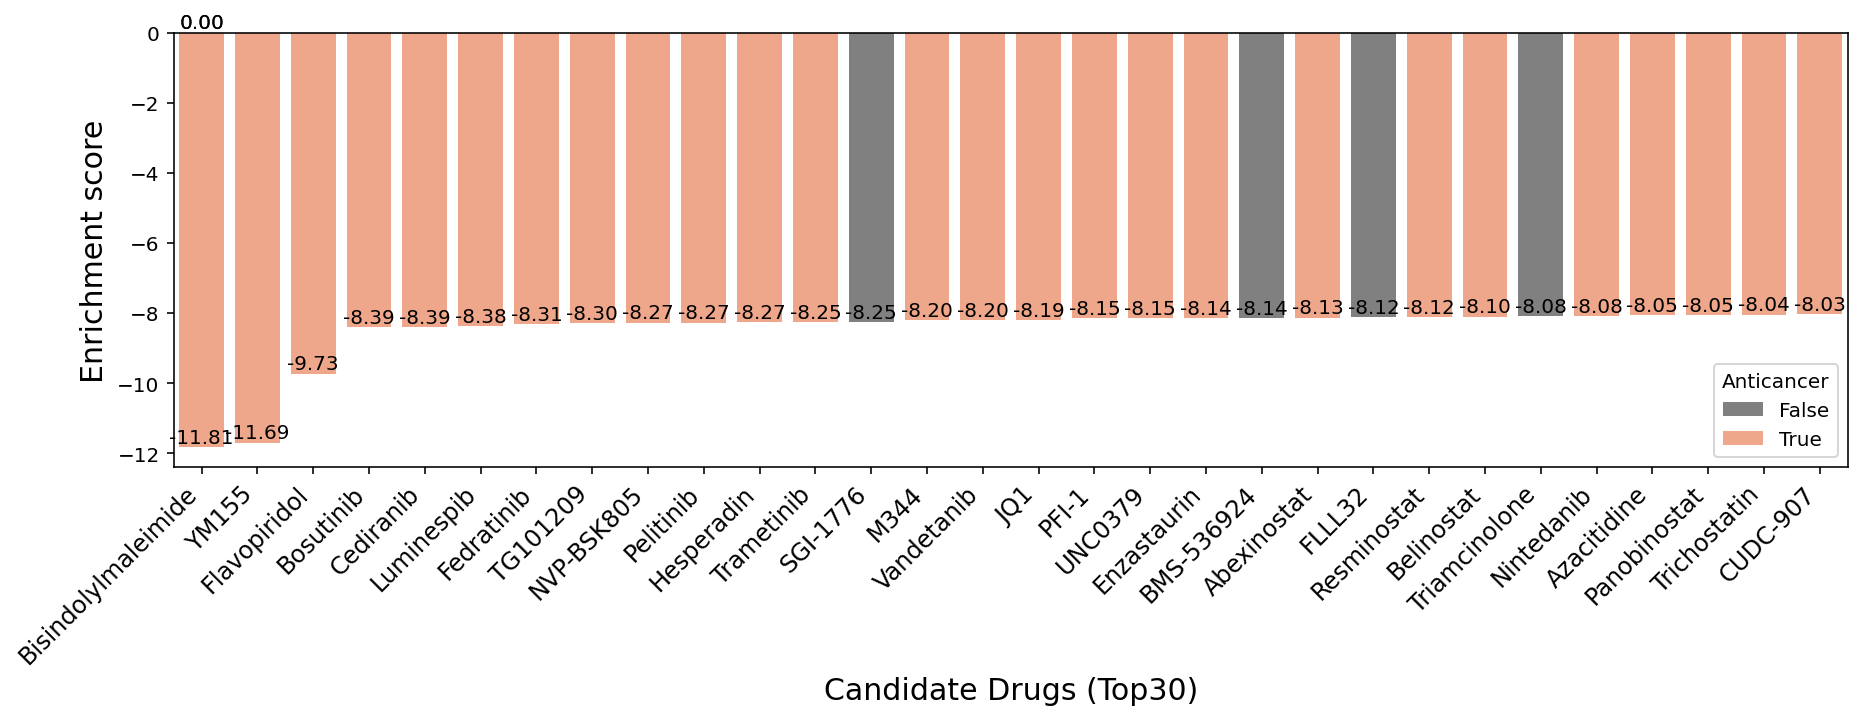

In [13]:
# Plot the Top30 candidate drugs
score_df_sort['Anticancer'] = score_df_sort['drugs'].isin(anti_drugs)
plt.figure(figsize=(15, 4))
palette_colors = {True: 'lightsalmon', False: 'gray'}

ax = sns.barplot(data=score_df_sort.iloc[:30, :], x='drugs', y='scores',hue='Anticancer',palette=palette_colors)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width()/2, p.get_height()),  # 位置
                ha='center', va='bottom', fontsize=10, color='black')
    
plt.xticks(rotation=45, ha='right',fontsize=12)
plt.xlabel('Candidate Drugs (Top30)',fontdict={'fontsize':15})
plt.ylabel('Enrichment score',fontdict={'fontsize':15}) 

plt.savefig('/Users/liuxinyuan/Desktop/perturb_project/benchmark_codes/plots/gsea/bar_score.png',dpi=300,bbox_inches='tight')

Plot precision and recall of reference anticancer drugs

In [25]:
# We plot precision and recall of down-regulated terms, since there is few or no up-regulated pathway terms in ground truth
neg_pre = []
neg_recall = []
length = []
sel_drugs = []
for k,v in re.items():
    if k in anti_drugs:
        sel_drugs.append(k)
        neg_pre.append(v['neg_pre'])
        neg_recall.append(v['neg_recall'])
        length.append(v['neg'])
        
anti_df = pd.DataFrame({'drugs':sel_drugs,'neg_precision':neg_pre,'neg_recall':neg_recall})

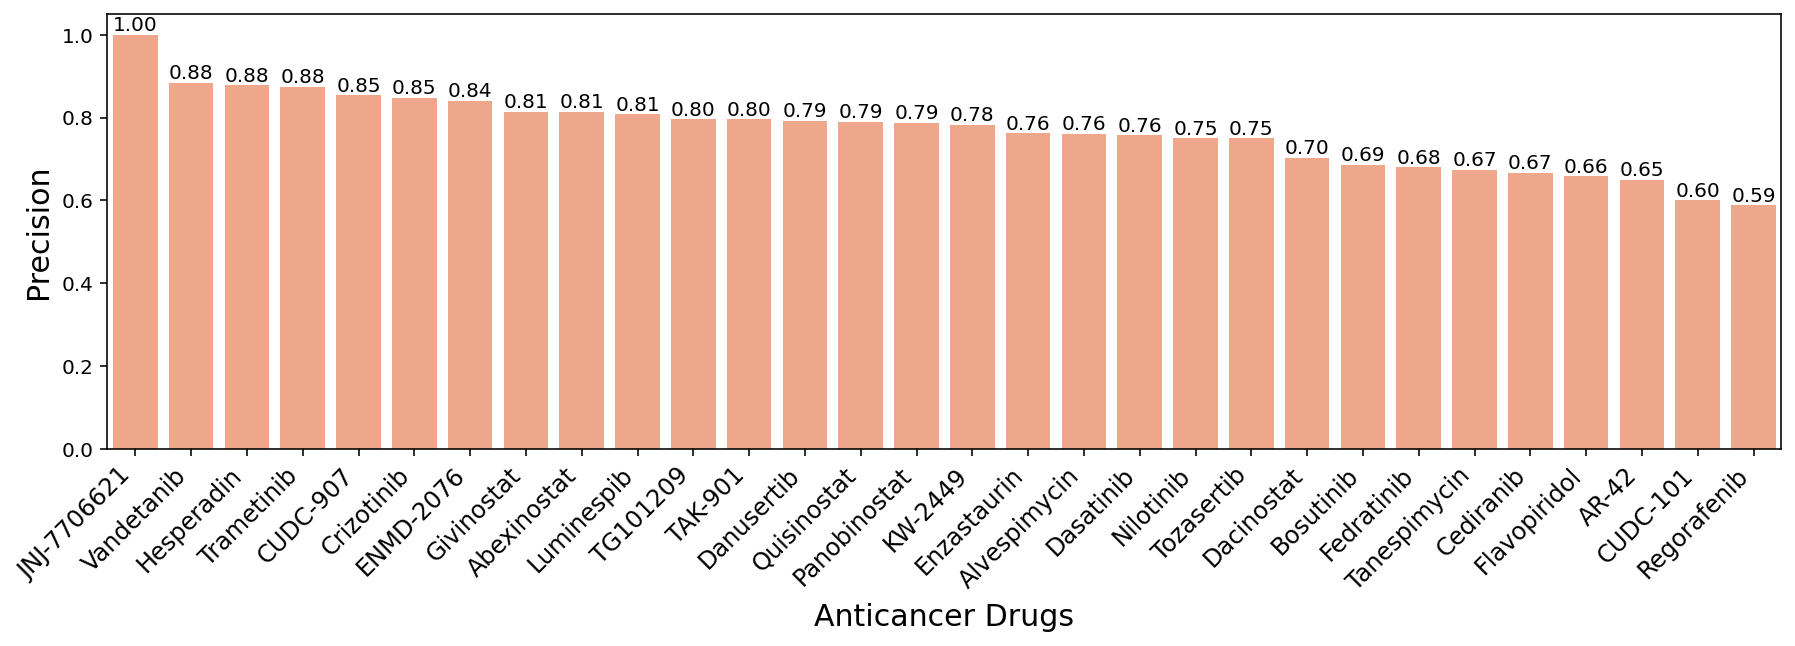

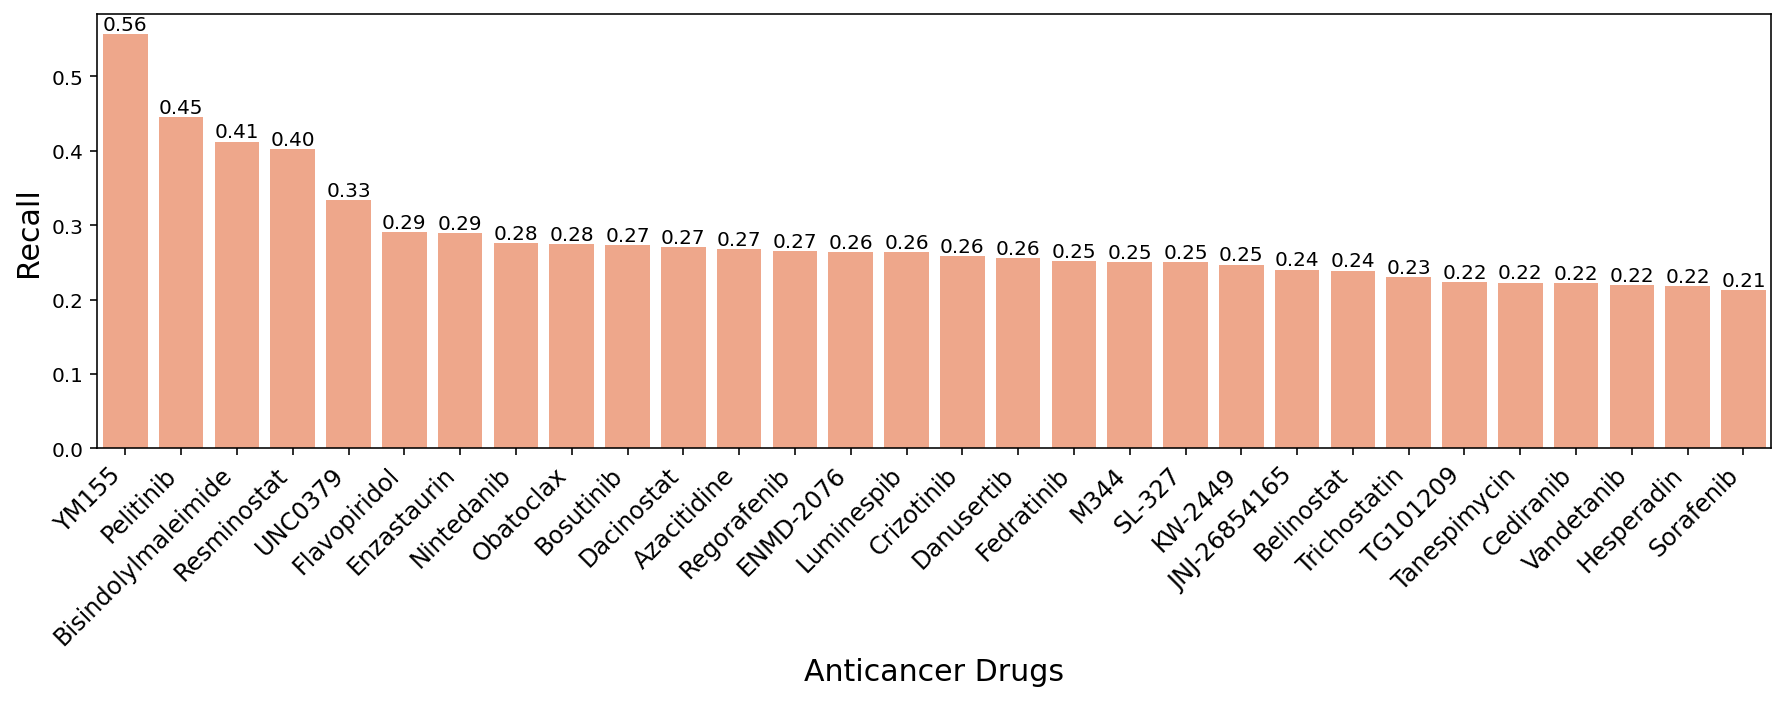

In [17]:
anti_df_sort = anti_df.sort_values(by='neg_precision',ascending=False)
plt.figure(figsize=(15, 4))
ax = sns.barplot(data=anti_df_sort.iloc[:30, :], x='drugs', y='neg_precision',color='lightsalmon')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')
    
plt.xticks(rotation=45, ha='right',fontsize=12)
plt.xlabel('Anticancer Drugs',fontdict={'fontsize':15})
plt.ylabel('Precision',fontdict={'fontsize':15}) 

plt.savefig('./gsea/bar_pre.png',dpi=300,bbox_inches='tight')

anti_df_sort = anti_df.sort_values(by='neg_recall',ascending=False)
plt.figure(figsize=(15, 4))
ax = sns.barplot(data=anti_df_sort.iloc[:30, :], x='drugs', y='neg_recall',color='lightsalmon')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
    
plt.xticks(rotation=45, ha='right',fontsize=12)
plt.xlabel('Anticancer Drugs',fontdict={'fontsize':15})
plt.ylabel('Recall',fontdict={'fontsize':15}) 
plt.savefig('./gsea/bar_recall.png',dpi=300,bbox_inches='tight')

In [26]:
neg_pre_na = []
neg_recall_na = []
length_na = []
drug_na = []
for k,v in re.items():
    if k not in anti_drugs:
        drug_na.append(k)
        neg_pre_na.append(v['neg_acc'])
        neg_recall_na.append(v['neg_recall'])
        length_na.append(v['neg'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1688202b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1688207f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x168811fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x168820d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x16882e0a0>],
 'means': []}

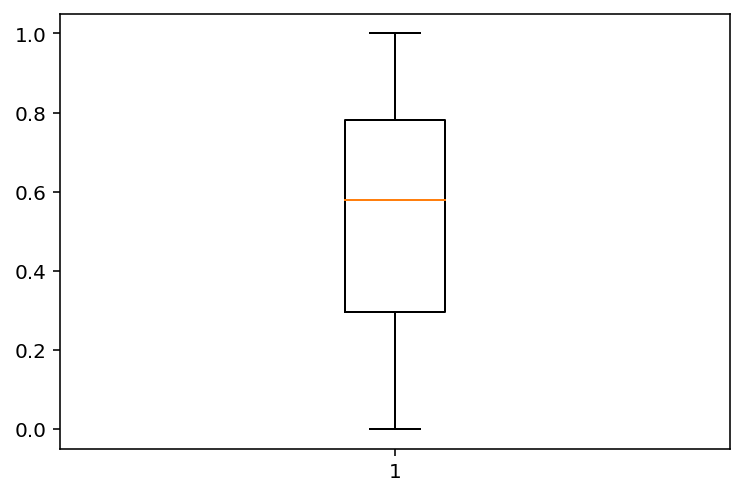

In [27]:
# Precision of anti-cancer drugs
plt.boxplot(neg_pre)

{'whiskers': [<matplotlib.lines.Line2D at 0x168856100>,
 'caps': [<matplotlib.lines.Line2D at 0x168856730>,
 'boxes': [<matplotlib.lines.Line2D at 0x1688508b0>],
 'medians': [<matplotlib.lines.Line2D at 0x168856d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x168856fd0>],
 'means': []}

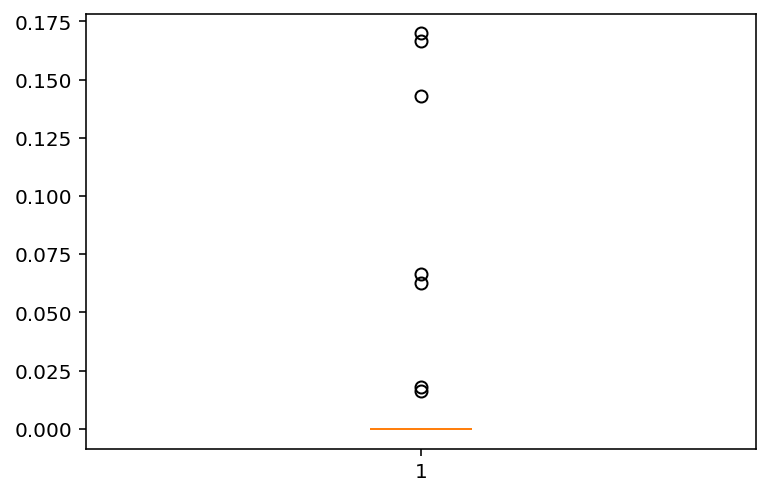

In [28]:
# Precision of non-cancer drugs. These are much lower, since there is less or no significant terms in ground truth data, 
plt.boxplot(neg_pre_na)